EXAMPLE 1: Simple 3-Variable QUBO Problem
QUBO Matrix Q:
[[-5  4  8]
 [ 0 -3  0]
 [ 0  0 -8]]

Ising Hamiltonian (num qubits: 3):
SparsePauliOp(['ZII', 'IZI', 'IIZ', 'ZZI', 'ZII', 'IZI', 'ZIZ', 'ZII', 'IIZ', 'III'],
              coeffs=[ 2.5+0.j,  1.5+0.j,  4. +0.j,  1. +0.j, -1. +0.j, -1. +0.j,  2. +0.j,
 -2. +0.j, -2. +0.j, -5. +0.j])

Solving with VQE...
Beginning optimization with: COBYLA
Optimization finished

Sampling optimized state...

Top 3 measurement results:
  1. |011⟩: prob=1.0000, x=[0 1 1], objective=-11.00
  2. |110⟩: prob=0.0000, x=[1 1 0], objective=-4.00
  3. |111⟩: prob=0.0000, x=[1 1 1], objective=-4.00

Best solution found: x = [0 1 1]
Objective value: -11.00

Verification (brute force search):
Optimal solution: x = [0 1 1], objective = -11.00


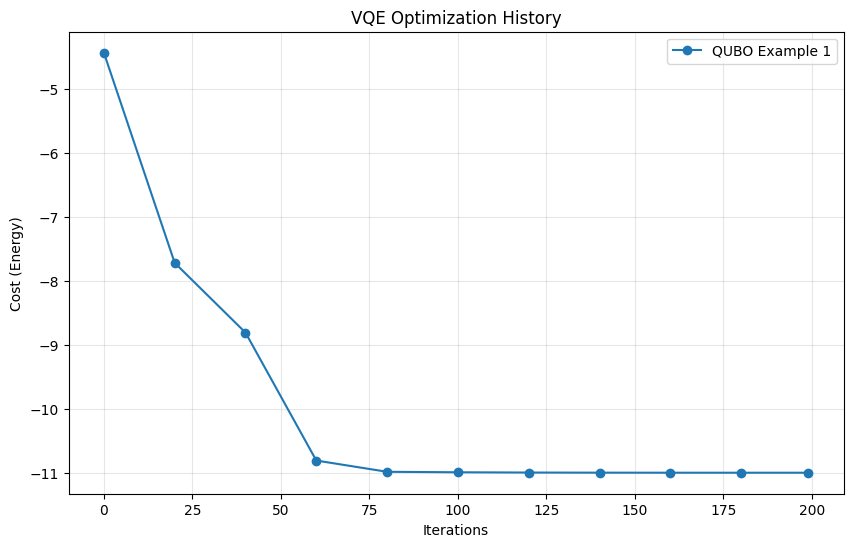


EXAMPLE 2: Max-Cut Problem (Graph Partitioning)
Graph with 4 nodes and edges: [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]

QUBO Matrix Q:
[[-2.  2.  2.  0.]
 [ 0. -3.  2.  2.]
 [ 0.  0. -3.  2.]
 [ 0.  0.  0. -2.]]

Solving Max-Cut with VQE...
Beginning optimization with: SLSQP
Optimization finished

Top solutions:
  1. |0110⟩: prob=0.5000, partition=[0 1 1 0], cut_edges=4, objective=-4.00
  2. |1001⟩: prob=0.5000, partition=[1 0 0 1], cut_edges=4, objective=-4.00
  3. |1011⟩: prob=0.0000, partition=[1 0 1 1], cut_edges=3, objective=-3.00
  4. |0011⟩: prob=0.0000, partition=[0 0 1 1], cut_edges=3, objective=-3.00
  5. |0001⟩: prob=0.0000, partition=[0 0 0 1], cut_edges=2, objective=-2.00

Best partition: [0 1 1 0]
Number of cut edges: 4 out of 5


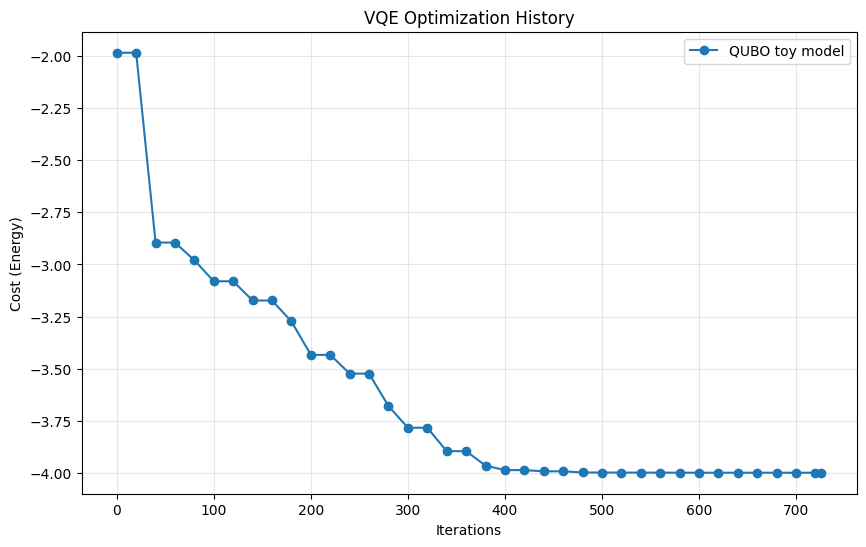


EXAMPLE 3: Number Partitioning Problem
Numbers to partition: [ 3  1  5  9 12]
Total sum: 30

QUBO Matrix Q:
[[ -81.    6.   30.   54.   72.]
 [   0.  -29.   10.   18.   24.]
 [   0.    0. -125.   90.  120.]
 [   0.    0.    0. -189.  216.]
 [   0.    0.    0.    0. -216.]]

Solving Number Partitioning with VQE...
Beginning optimization with: Powell
Optimization finished

Top solutions:
  1. |10001⟩: prob=0.9613
      Set 1: [ 3 12] (sum=15)
      Set 2: [1 5 9] (sum=15)
      Difference: 0
  2. |00110⟩: prob=0.0239
      Set 1: [5 9] (sum=14)
      Set 2: [ 3  1 12] (sum=16)
      Difference: 2
  3. |01110⟩: prob=0.0082
      Set 1: [1 5 9] (sum=15)
      Set 2: [ 3 12] (sum=15)
      Difference: 0
  4. |10110⟩: prob=0.0059
      Set 1: [3 5 9] (sum=17)
      Set 2: [ 1 12] (sum=13)
      Difference: 4
  5. |00101⟩: prob=0.0002
      Set 1: [ 5 12] (sum=17)
      Set 2: [3 1 9] (sum=13)
      Difference: 4


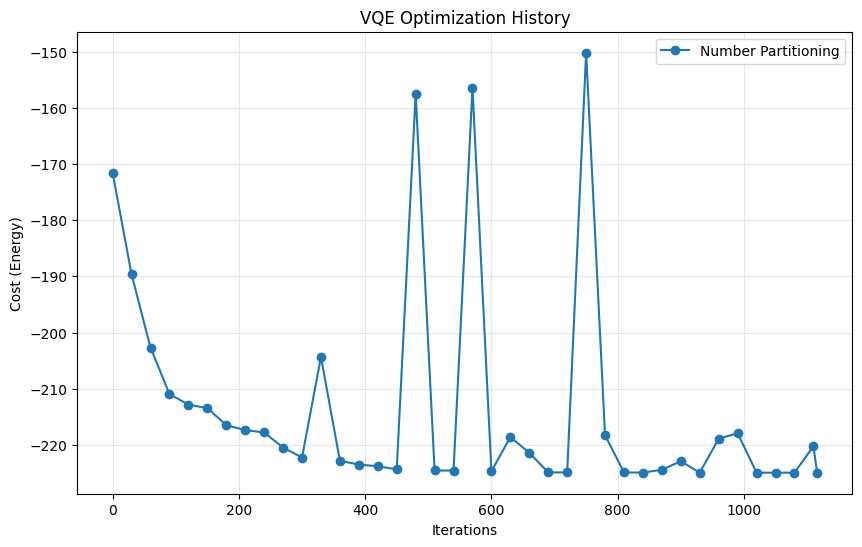


BONUS: QUBO Solver Wrapper Class
Using QUBOSolver wrapper class:

Beginning optimization with: COBYLA
Optimization finished
Best solution: [0 1 1]
Objective value: -11.00

Top 3 solutions:
  1. x=[0 1 1], objective=-11.00, prob=0.9982
  2. x=[1 1 0], objective=-4.00, prob=0.0012
  3. x=[1 0 1], objective=-5.00, prob=0.0005

All QUBO examples completed!


In [2]:
"""
Solving QUBO (Quadratic Unconstrained Binary Optimization) Problems with VQE

QUBO Problem: minimize x^T Q x, where x ∈ {0,1}^n
This is converted to an Ising Hamiltonian for VQE solution.
"""

import numpy as np
from qiskit.quantum_info import SparsePauliOp
from QUBO_VQE import VQESolver


def qubo_to_ising_hamiltonian(Q):
    """
    Convert a QUBO matrix Q to an Ising Hamiltonian.
    
    QUBO: minimize x^T Q x, where x ∈ {0,1}^n
    Ising: minimize sum_ij J_ij Z_i Z_j + sum_i h_i Z_i
    
    Conversion: x_i = (1 - Z_i)/2
    
    Args:
        Q: QUBO matrix (n x n numpy array)
        
    Returns:
        SparsePauliOp representing the Ising Hamiltonian
    """
    n = Q.shape[0]
    
    # Build Pauli operator list
    pauli_list = []
    constant = 0.0
    
    # Diagonal terms: Q_ii * x_i = Q_ii * (1 - Z_i)/2
    for i in range(n):
        if Q[i, i] != 0:
            # Linear term: -Q_ii/2 * Z_i
            pauli_str = ['I'] * n
            pauli_str[i] = 'Z'
            pauli_list.append((''.join(pauli_str), -Q[i, i] / 2))
            
            # Constant term: Q_ii/2
            constant += Q[i, i] / 2
    
    # Off-diagonal terms: Q_ij * x_i * x_j = Q_ij * (1-Z_i)(1-Z_j)/4
    for i in range(n):
        for j in range(i + 1, n):
            if Q[i, j] != 0 or Q[j, i] != 0:
                Q_ij = Q[i, j] + Q[j, i]  # Symmetrize
                
                # ZZ term: Q_ij/4 * Z_i Z_j
                pauli_str = ['I'] * n
                pauli_str[i] = 'Z'
                pauli_str[j] = 'Z'
                pauli_list.append((''.join(pauli_str), Q_ij / 4))
                
                # Z_i term: -Q_ij/4 * Z_i
                pauli_str = ['I'] * n
                pauli_str[i] = 'Z'
                pauli_list.append((''.join(pauli_str), -Q_ij / 4))
                
                # Z_j term: -Q_ij/4 * Z_j
                pauli_str = ['I'] * n
                pauli_str[j] = 'Z'
                pauli_list.append((''.join(pauli_str), -Q_ij / 4))
                
                # Constant: Q_ij/4
                constant += Q_ij / 4
    
    # Add constant term as identity
    if constant != 0:
        pauli_list.append(('I' * n, constant))
    
    return SparsePauliOp.from_list(pauli_list)


def ising_to_binary(bitstring):
    """
    Convert Ising solution (0/1 bitstring) to binary solution.
    In Qiskit measurement, |0⟩ corresponds to Z=+1 and |1⟩ to Z=-1
    For QUBO: x_i = (1 - Z_i)/2, so x_i = 1 when Z_i = -1 (measured as |1⟩)
    
    Args:
        bitstring: string of '0' and '1'
        
    Returns:
        numpy array of binary values
    """
    # The bitstring from measurement is already in the correct format:
    # '1' means x_i = 1, '0' means x_i = 0
    return np.array([int(b) for b in bitstring])


def evaluate_qubo(Q, x):
    """
    Evaluate QUBO objective: x^T Q x
    
    Args:
        Q: QUBO matrix
        x: binary solution vector
        
    Returns:
        Objective value
    """
    return x.T @ Q @ x


# ============================================================================
# EXAMPLE 1: Simple 3-variable QUBO
# ============================================================================
print("=" * 70)
print("EXAMPLE 1: Simple 3-Variable QUBO Problem")
print("=" * 70)

# Define QUBO matrix
# minimize: -5*x0 - 3*x1 - 8*x2 + 4*x0*x1 + 8*x0*x2
Q1 = np.array([
    [-5,  4,  8],
    [ 0, -3,  0],
    [ 0,  0, -8]
])

print("QUBO Matrix Q:")
print(Q1)

# Convert to Ising Hamiltonian
hamiltonian1 = qubo_to_ising_hamiltonian(Q1)
print(f"\nIsing Hamiltonian (num qubits: {hamiltonian1.num_qubits}):")
print(hamiltonian1)

# Solve with VQE
vqe1 = VQESolver()
vqe1.set_hamiltonian(hamiltonian1)
vqe1.set_ansatz_type('RealAmplitudes', reps=3)

print(f"\nSolving with VQE...")
optimal_params1 = vqe1.solve(
    maxiter=200,
    optimizer='COBYLA',
    callback_step_size=20
)

# Get the solution
print("\nSampling optimized state...")
stats1 = vqe1.sample_circuit(optimal_params1)

# Find best solution
sorted_stats1 = sorted(stats1.items(), key=lambda x: x[1], reverse=True)
best_bitstring1 = bin(sorted_stats1[0][0])[2:].zfill(3)
best_solution1 = ising_to_binary(best_bitstring1)

print(f"\nTop 3 measurement results:")
for i, (state, prob) in enumerate(sorted_stats1[:3]):
    bitstring = bin(state)[2:].zfill(3)
    solution = ising_to_binary(bitstring)
    obj_value = evaluate_qubo(Q1, solution)
    print(f"  {i+1}. |{bitstring}⟩: prob={prob:.4f}, x={solution}, objective={obj_value:.2f}")

print(f"\nBest solution found: x = {best_solution1}")
print(f"Objective value: {evaluate_qubo(Q1, best_solution1):.2f}")

# Verify by brute force
print("\nVerification (brute force search):")
best_obj = float('inf')
best_x = None
for i in range(2**3):
    x = np.array([int(b) for b in bin(i)[2:].zfill(3)])
    obj = evaluate_qubo(Q1, x)
    if obj < best_obj:
        best_obj = obj
        best_x = x
print(f"Optimal solution: x = {best_x}, objective = {best_obj:.2f}")

vqe1.plot_optimization_history(legend='QUBO Example 1')


# ============================================================================
# EXAMPLE 2: Max-Cut Problem as QUBO
# ============================================================================
print("\n" + "=" * 70)
print("EXAMPLE 2: Max-Cut Problem (Graph Partitioning)")
print("=" * 70)

# Max-Cut on a 4-node graph
# Graph edges: (0,1), (0,2), (1,2), (1,3), (2,3)
# Goal: partition nodes into two sets to maximize cut edges

def maxcut_to_qubo(edges, num_nodes):
    """
    Convert Max-Cut problem to QUBO.
    Max-Cut: maximize number of edges between partitions
    QUBO formulation: minimize -sum_{(i,j) in edges} (x_i + x_j - 2*x_i*x_j)
    
    This simplifies to: minimize sum_{(i,j)} (2*x_i*x_j - x_i - x_j)
    """
    Q = np.zeros((num_nodes, num_nodes))
    
    for i, j in edges:
        Q[i, i] -= 1
        Q[j, j] -= 1
        Q[i, j] += 2  # Off-diagonal
    
    return Q

edges = [(0, 1), (0, 2), (1, 2), (1, 3), (2, 3)]
num_nodes = 4

Q2 = maxcut_to_qubo(edges, num_nodes)

print(f"Graph with {num_nodes} nodes and edges: {edges}")
print("\nQUBO Matrix Q:")
print(Q2)

# Convert to Hamiltonian and solve
hamiltonian2 = qubo_to_ising_hamiltonian(Q2)

vqe2 = VQESolver()
vqe2.set_hamiltonian(hamiltonian2)
vqe2.set_ansatz_type('EfficientSU2', reps=3)

print(f"\nSolving Max-Cut with VQE...")
optimal_params2 = vqe2.solve(
    maxiter=200,
    optimizer='SLSQP',
    callback_step_size=20
)

# Get solution
stats2 = vqe2.sample_circuit(optimal_params2)
sorted_stats2 = sorted(stats2.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop solutions:")
for i, (state, prob) in enumerate(sorted_stats2[:5]):
    bitstring = bin(state)[2:].zfill(num_nodes)
    solution = ising_to_binary(bitstring)
    obj_value = evaluate_qubo(Q2, solution)
    
    # Count cut edges
    cut_edges = sum(1 for u, v in edges if solution[u] != solution[v])
    
    print(f"  {i+1}. |{bitstring}⟩: prob={prob:.4f}, partition={solution}, "
          f"cut_edges={cut_edges}, objective={obj_value:.2f}")

best_bitstring2 = bin(sorted_stats2[0][0])[2:].zfill(num_nodes)
best_solution2 = ising_to_binary(best_bitstring2)
best_cut = sum(1 for u, v in edges if best_solution2[u] != best_solution2[v])

print(f"\nBest partition: {best_solution2}")
print(f"Number of cut edges: {best_cut} out of {len(edges)}")

vqe2.plot_optimization_history(legend='QUBO toy model')


# ============================================================================
# EXAMPLE 3: Number Partitioning Problem
# ============================================================================
print("\n" + "=" * 70)
print("EXAMPLE 3: Number Partitioning Problem")
print("=" * 70)

# Given numbers, partition into two sets with equal sums
# Numbers to partition
numbers = np.array([3, 1, 5, 9, 12])
n = len(numbers)

print(f"Numbers to partition: {numbers}")
print(f"Total sum: {np.sum(numbers)}")

# QUBO formulation: minimize (sum_i numbers[i] * x_i - S/2)^2
# where S = sum of all numbers
S = np.sum(numbers)

# Expand: minimize sum_i numbers[i]^2 * x_i + 2*sum_{i<j} numbers[i]*numbers[j]*x_i*x_j - S*sum_i numbers[i]*x_i + S^2/4
# Q_ii = numbers[i]^2 - S * numbers[i]
# Q_ij = 2 * numbers[i] * numbers[j]

Q3 = np.zeros((n, n))
for i in range(n):
    Q3[i, i] = numbers[i]**2 - S * numbers[i]
    for j in range(i + 1, n):
        Q3[i, j] = 2 * numbers[i] * numbers[j]

print("\nQUBO Matrix Q:")
print(Q3)

# Solve with VQE
hamiltonian3 = qubo_to_ising_hamiltonian(Q3)

vqe3 = VQESolver()
vqe3.set_hamiltonian(hamiltonian3)
vqe3.set_ansatz_type('RealAmplitudes', reps=4)

print(f"\nSolving Number Partitioning with VQE...")
optimal_params3 = vqe3.solve(
    maxiter=300,
    optimizer='Powell',
    callback_step_size=30
)

# Get solutions
stats3 = vqe3.sample_circuit(optimal_params3)
sorted_stats3 = sorted(stats3.items(), key=lambda x: x[1], reverse=True)

print(f"\nTop solutions:")
for i, (state, prob) in enumerate(sorted_stats3[:5]):
    bitstring = bin(state)[2:].zfill(n)
    solution = ising_to_binary(bitstring)
    
    set1 = numbers[solution == 1]
    set2 = numbers[solution == 0]
    sum1 = np.sum(set1)
    sum2 = np.sum(set2)
    diff = abs(sum1 - sum2)
    
    print(f"  {i+1}. |{bitstring}⟩: prob={prob:.4f}")
    print(f"      Set 1: {set1} (sum={sum1})")
    print(f"      Set 2: {set2} (sum={sum2})")
    print(f"      Difference: {diff}")

vqe3.plot_optimization_history(legend='Number Partitioning')


# ============================================================================
# HELPER CLASS: QUBO Solver Wrapper
# ============================================================================
print("\n" + "=" * 70)
print("BONUS: QUBO Solver Wrapper Class")
print("=" * 70)

class QUBOSolver:
    """Convenience wrapper for solving QUBO problems with VQE."""
    
    def __init__(self, Q):
        """
        Initialize QUBO solver.
        
        Args:
            Q: QUBO matrix (n x n numpy array)
        """
        self.Q = Q
        self.n = Q.shape[0]
        self.hamiltonian = qubo_to_ising_hamiltonian(Q)
        self.vqe = VQESolver()
        self.vqe.set_hamiltonian(self.hamiltonian)
        self.best_solution = None
        self.best_objective = None
    
    def solve(self, ansatz_type='RealAmplitudes', reps=3, 
              maxiter=200, optimizer='COBYLA', **kwargs):
        """Solve the QUBO problem."""
        self.vqe.set_ansatz_type(ansatz_type, reps=reps)
        optimal_params = self.vqe.solve(maxiter=maxiter, optimizer=optimizer, **kwargs)
        
        # Extract best solution
        stats = self.vqe.sample_circuit(optimal_params)
        best_state = max(stats, key=stats.get)
        bitstring = bin(best_state)[2:].zfill(self.n)
        self.best_solution = ising_to_binary(bitstring)
        self.best_objective = evaluate_qubo(self.Q, self.best_solution)
        
        return self.best_solution, self.best_objective
    
    def get_top_solutions(self, k=5):
        """Get top k solutions."""
        stats = self.vqe._last_sampler_stats
        if stats is None:
            raise ValueError("No solution available. Run solve() first.")
        
        sorted_stats = sorted(stats.items(), key=lambda x: x[1], reverse=True)
        solutions = []
        
        for state, prob in sorted_stats[:k]:
            bitstring = bin(state)[2:].zfill(self.n)
            solution = ising_to_binary(bitstring)
            objective = evaluate_qubo(self.Q, solution)
            solutions.append((solution, objective, prob))
        
        return solutions

# Example usage of wrapper
print("Using QUBOSolver wrapper class:\n")

qubo_solver = QUBOSolver(Q1)
solution, objective = qubo_solver.solve(maxiter=150, optimizer='COBYLA')

print(f"Best solution: {solution}")
print(f"Objective value: {objective:.2f}")

print("\nTop 3 solutions:")
for i, (sol, obj, prob) in enumerate(qubo_solver.get_top_solutions(3)):
    print(f"  {i+1}. x={sol}, objective={obj:.2f}, prob={prob:.4f}")

print("\n" + "=" * 70)
print("All QUBO examples completed!")
print("=" * 70)